In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression,Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [144]:
df = pd.read_csv("ds_salaries.csv")

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [146]:
#We can elminate non-fulltime jobs
df["employment_type"].value_counts()

df_full_time = df[df["employment_type"]=="FT"]
df_full_time.reset_index(drop = True,inplace=True)
df_full_time.drop(axis=1,columns="employment_type",inplace=True)

/tmp/ipykernel_6949/2092827558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_time.drop(axis=1,columns="employment_type",inplace=True)


In [147]:
obj_cols = df_full_time.select_dtypes("object").columns
df_full_time[obj_cols].nunique()

experience_level       4
job_title             92
salary_currency       20
employee_residence    73
company_location      68
company_size           3
dtype: int64

[Text(0, 0, '2020'),
 Text(1, 0, '2021'),
 Text(2, 0, '2022'),
 Text(3, 0, '2023')]

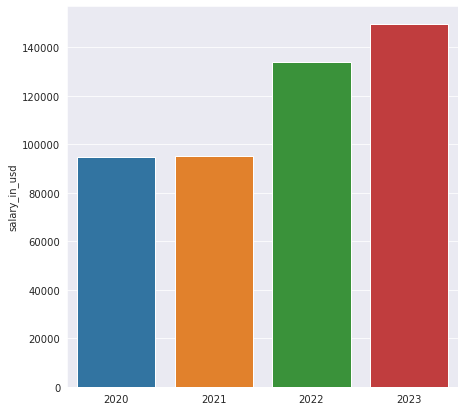

In [148]:
#salary means by years
plt.figure(figsize=(7,7))
sns.set_style("darkgrid")
salary_mean_by_year = df_full_time[["work_year","salary_in_usd"]].groupby("work_year").mean().reset_index()
g = sns.barplot(data=salary_mean_by_year,x=salary_mean_by_year.index,y="salary_in_usd")
g.set_xticks(range(len(salary_mean_by_year)))
g.set_xticklabels(salary_mean_by_year["work_year"])



[Text(0, 0, 'Office'), Text(1, 0, 'Hybrid'), Text(2, 0, 'Remote')]

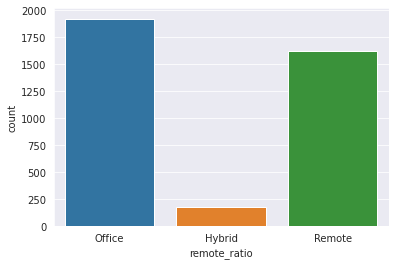

In [149]:
#Job Types
g = sns.countplot(data=df_full_time,x="remote_ratio")
g.set_xticklabels(["Office","Hybrid","Remote"])


<AxesSubplot:xlabel='company_location', ylabel='salary_in_usd'>

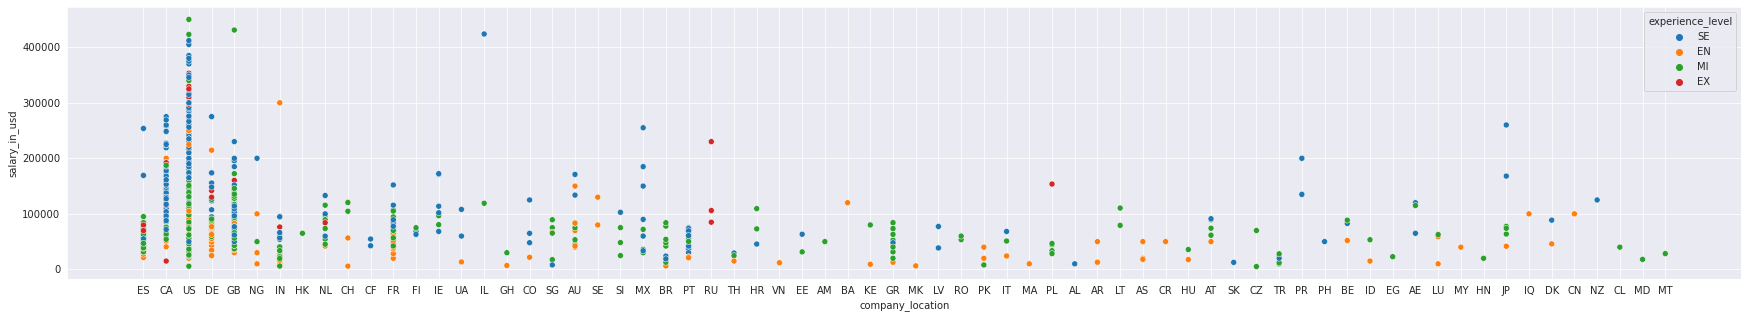

In [150]:
#Salaries based on location
plt.figure(figsize=(30,5))
sns.scatterplot(data=df_full_time,x="company_location",y="salary_in_usd",hue="experience_level")

/tmp/ipykernel_6949/10844514.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  company_size_df = df_full_time.groupby("company_size").mean().reset_index()


<AxesSubplot:xlabel='company_size', ylabel='salary_in_usd'>

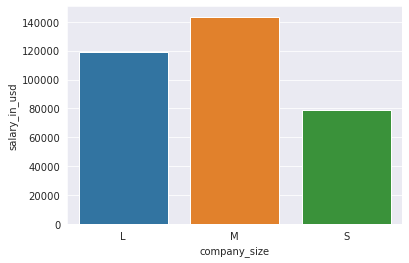

In [151]:
#Does company size affect salary? After small, no so much
company_size_df = df_full_time.groupby("company_size").mean().reset_index()
sns.barplot(data=company_size_df,x="company_size",y="salary_in_usd")

In [152]:
#Building a salary prediction model
main_df = df_full_time[["work_year","experience_level","salary_in_usd","remote_ratio","company_size"]]

In [153]:
X = main_df[["work_year","experience_level","remote_ratio","company_size"]]
Y = main_df["salary_in_usd"]

In [154]:
size_le = LabelEncoder()
size_le.classes_=["S","M","L"]
X["company_size_encoded"]=size_le.transform(X["company_size"])

exp_le = LabelEncoder()
exp_le.classes_=["EN","MI","SE","EX"]
X["exp_level_encoded"]=exp_le.transform(X["experience_level"])

X = X[["work_year","company_size_encoded","exp_level_encoded","remote_ratio"]]

In [187]:
def preprocess(data):
    data_copy = data.copy()

    data_copy["exp_level_encoded"] = exp_le.transform(data_copy["experience_level"])
    data_copy["company_size_encoded"] = size_le.transform(data_copy["company_size"])
    data_copy.drop(axis=1,columns=["company_size","experience_level"],inplace=True)

    return data_copy 

In [188]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [189]:
def fit_and_test(model,train_x,train_y,test_x,test_y):

    model.fit(train_x,train_y)
    preds = model.predict(test_x)

    err = np.sqrt(mean_squared_error(test_y,preds))
                  
    print(f"MODEL:{model} --- MSRE={err}")

    return err



In [190]:
#None of our models give a satisfactory result, I think it's about the lack of data and features.
models = [RandomForestRegressor(),LinearRegression(),Perceptron()]
for mod in models:
    fit_and_test(mod,X_train,y_train,X_test,y_test)

MODEL:RandomForestRegressor() --- MSRE=55605.883238436036
MODEL:LinearRegression() --- MSRE=55346.49965055627
MODEL:Perceptron() --- MSRE=74236.50631995515


In [191]:
lr = LinearRegression()
lr.fit(X_train,y_train)
example_entry = pd.DataFrame.from_dict(data={"work_year":[2022],"company_size":["L"],"remote_ratio":[100],"experience_level":["EX"]})

In [192]:
processed_entry = preprocess(example_entry)

In [193]:
processed_entry

,work_year,remote_ratio,exp_level_encoded,company_size_encoded
0,2022,100,3,2


In [194]:
lr.predict(processed_entry)

/home/salihboraguder/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([1020582.03755572])